# Azure ML service and Excel integration

<img src="https://docs.microsoft.com/en-us/azure/machine-learning/service/media/overview-what-is-azure-ml/aml.png">

> Documentation: https://docs.microsoft.com/en-us/azure/machine-learning/

Agenda:
    1. We are going to create a simple scikit learn model on the Boston Dataset
    2. We will deploy the model with Azure Container instance (ACI)
    3. We will test the deployed model
    4. Then we will use an Excel sheet to use the deployed model

## 1. Informations

In [1]:
import datetime
now = datetime.datetime.now()
print(now)

2019-11-25 17:48:16.872447


In [2]:
import sys
print("Python version: ",sys.version)

Python version:  3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


### Installing or upgrading Azure ML SDK

In [3]:
#!pip install azureml-sdk

In [4]:
#!pip install --upgrade azureml-sdk

## 2. Connection to the Azure ML workspace

In [5]:
# Workspace
import os
subscription_id = os.environ.get("SUBSCRIPTION_ID", "YourAzureID")
resource_group = os.environ.get("RESOURCE_GROUP", "azuremlserviceresourcegroup")
workspace_name = os.environ.get("WORKSPACE_NAME", "azuremlservice")

In [6]:
from azureml.core import Workspace
try:
   ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
   ws.write_config()
   print("OK")
except:
   print("Error: Workspace not found")

OK


In [7]:
import azureml.core
from azureml.core.workspace import Workspace
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from azureml.core.model import Model
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from azureml.core import Environment
from azureml.core.model import InferenceConfig

print("Azure ML service version:", azureml.core.VERSION)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Azure ML service version: 1.0.74


In [8]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, sep='\n')

azuremlservice
azuremlserviceresourcegroup
westeurope


## 3. ML

### Boston dataset example

Feature Descriptions				
1. CRIM - per capita crime rate by town				
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.				
3. INDUS - proportion of non-retail business acres per town.				
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)				
5. NOX - nitric oxides concentration (parts per 10 million)				
6. RM - average number of rooms per dwelling				
7. AGE - proportion of owner-occupied units built prior to 1940				
8. DIS - weighted distances to five Boston employment centres				
9. RAD - index of accessibility to radial highways				
10. TAX - full-value property-tax rate per $10000	

11. PTRATIO - pupil-teacher ratio by town				
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town				
13. LSTAT - pct lower status of the population				
14. MEDV - Median value of owner-occupied homes in $1000's

In [9]:
boston = load_boston()
bos = pd.DataFrame(boston.data)
bos.columns = boston.feature_names
bos['PRICE'] = boston.target

In [10]:
bos.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2

In [11]:
bos.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT       PRICE  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

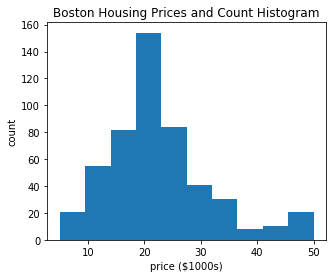

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
boston = load_boston()
plt.figure(figsize=(5, 4))
plt.hist(boston.target)
plt.title('Boston Housing Prices and Count Histogram')
plt.xlabel('price ($1000s)')
plt.ylabel('count')
plt.show()

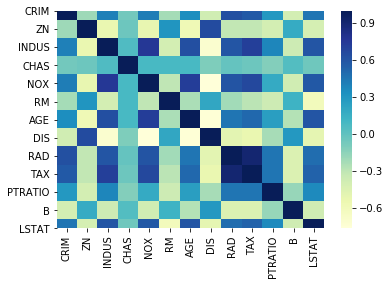

In [13]:
import seaborn as sns
 
boston = load_boston()
boston_pd = pd.DataFrame(boston.data, columns = boston.feature_names)
correlation_matrix = boston_pd.corr().round(2)
sns.heatmap(correlation_matrix, cmap="YlGnBu")
plt.show()

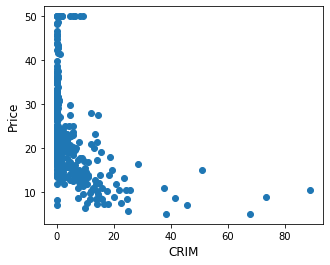

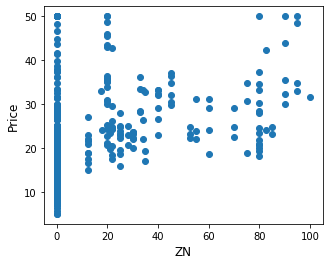

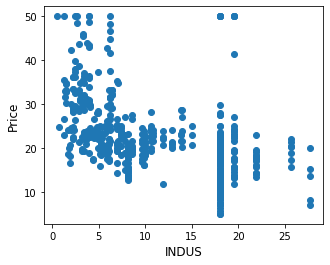

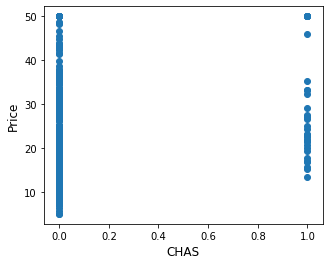

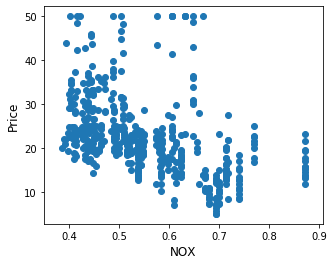

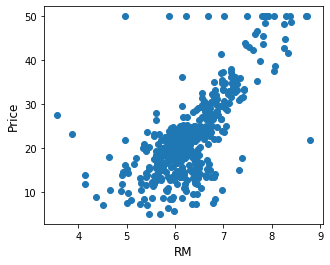

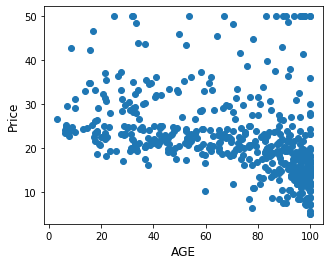

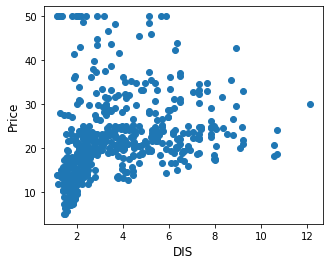

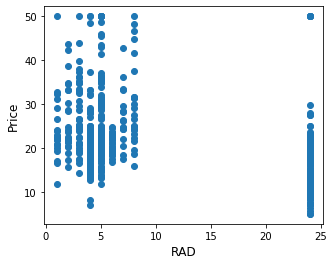

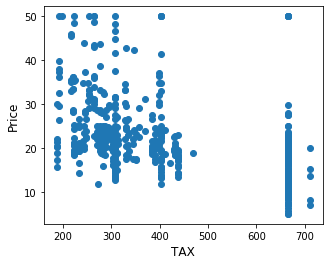

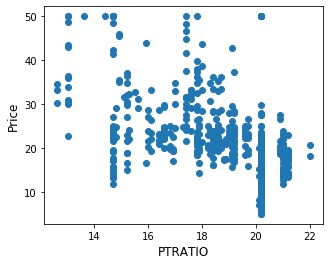

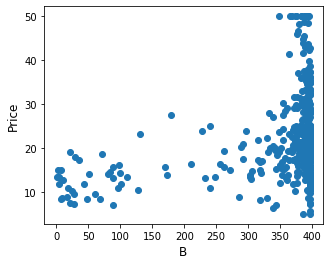

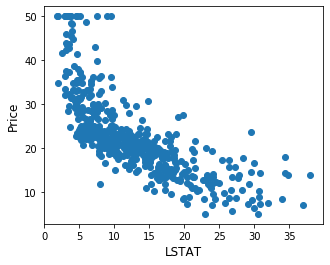

In [14]:
for index, feature_name in enumerate(boston.feature_names):
    plt.figure(figsize=(5, 4))
    plt.scatter(boston.data[:, index], boston.target)
    plt.ylabel('Price', size=12)
    plt.xlabel(feature_name, size=12)
    plt.show()

In [15]:
X = bos.drop('PRICE', axis = 1)
Y = bos['PRICE']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 5)

In [16]:
lm = LinearRegression()
lm.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
# The coefficients
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [-1.56381297e-01  3.85490972e-02 -2.50629921e-02  7.86439684e-01
 -1.29469121e+01  4.00268857e+00 -1.16023395e-02 -1.36828811e+00
  3.41756915e-01 -1.35148823e-02 -9.88866034e-01  1.20588215e-02
 -4.72644280e-01]


In [18]:
import numpy as np
print('R2 Test =', np.round(lm.score(X_test,Y_test)*100,2))
print('R2 Training=', np.round(lm.score(X_train,Y_train)*100,2))

R2 Test = 69.57
R2 Training= 75.51


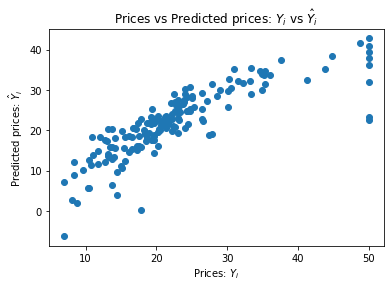

In [19]:
Y_pred = lm.predict(X_test)
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Let's register the ML model

In [20]:
model_file_name = 'boston_model.pkl'
joblib.dump(value = lm, filename = model_file_name)

registered_trained_model = Model.register(workspace=ws, model_path=model_file_name, model_name=model_file_name)

Registering model boston_model.pkl


## 4. Let's deploy the model to ACI

### 4.1 Generating the scoring file

In [21]:
%%writefile score.py
import pickle
import json
import numpy as np
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from azureml.core.model import Model

from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType

def init():
    global model
    # note here "sklearn_regression_model.pkl" is the name of the model registered under
    # this is a different behavior than before when the code is run locally, even though the code is the same.
    model_path = Model.get_model_path('boston_model.pkl')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

input_sample = np.array([[0.00632, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98]])
output_sample = np.array([3726.995])

@input_schema('data', NumpyParameterType(input_sample))
@output_schema(NumpyParameterType(output_sample))
def run(data):
    try:
        result = model.predict(data)
        # you can return any datatype as long as it is JSON-serializable
        return result.tolist()[0]
    except Exception as e:
        error = str(e)
        return error

Overwriting score.py


### 4.2 Environment file

In [22]:
%%writefile myenv.yml
name: project_environment
dependencies:
  - python=3.6.2
  - pip:
    - azureml-defaults
    - scikit-learn
    - numpy
    - pyspark
    - inference-schema[numpy-support]

Overwriting myenv.yml


In [23]:
env = Environment.from_conda_specification(name='deploytocloudenv', file_path='myenv.yml')
inference_config = InferenceConfig(entry_script="score.py", environment=env)

### 4.3 Deploying the ML model to ACI (Azure Container Instance)

In [24]:
%%time
from azureml.core.webservice import AciWebservice, Webservice
from azureml.exceptions import WebserviceException

deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)
aci_service_name = 'bostonhouseprice'

try:
    # if you want to get existing service below is the command
    # since aci name needs to be unique in subscription deleting existing aci if any
    # we use aci_service_name to create azure aci
    service = Webservice(ws, name=aci_service_name)
    if service:
        service.delete()
except WebserviceException as e:
    print()

service = Model.deploy(ws, aci_service_name, [registered_trained_model], inference_config, deployment_config)

service.wait_for_deployment(True)
print(service.state)

Running...........................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
CPU times: user 230 ms, sys: 19.5 ms, total: 250 ms
Wall time: 2min 23s


> Usually take 2 or 3 minutes to deploy into ACI

## 5. Testing

In [26]:
# This is the scoring endpoint
print("Azure ML Scoring endpoint is: ", service.scoring_uri)

Azure ML Scoring endpoint is:  http://bfe1588a-3cdc-4012-83f0-f536d0e047ab.westeurope.azurecontainer.io/score


### 5.1 Generating the input data into a JSON file

In [27]:
import json
test_sample = json.dumps({'data': [
    [0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98]]})

In [28]:
test_sample

'{"data": [[0.00632, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98]]}'

### 5.2 Let's test

In [29]:
test_sample_encoded = bytes(test_sample, encoding='utf8')

print("Input data: ")
print(test_sample_encoded)
prediction = service.run(input_data=test_sample_encoded)
print()
print("Price Model Prediction = ", prediction)

Input data: 
b'{"data": [[0.00632, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98]]}'

Price Model Prediction =  30.137479432585835


### Second test

In [30]:
import json
test_sample2 = json.dumps({'data': [
    [0.00432,16.0,1.1,0.12,0.422,6.75,65.2,4.0900,1.0,296.0,16.3,496.90,6.8]]})

In [31]:
test_sample_encoded = bytes(test_sample2, encoding='utf8')

print("Input data: ")
print(test_sample_encoded)
prediction = service.run(input_data=test_sample_encoded)
print()
print("Price Model Prediction = ", prediction)

Input data: 
b'{"data": [[0.00432, 16.0, 1.1, 0.12, 0.422, 6.75, 65.2, 4.09, 1.0, 296.0, 16.3, 496.9, 6.8]]}'

Price Model Prediction =  31.744508810239942


> End